In [1]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [2]:
df_mulvar = df[["bus", "rail"]] /1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar) # one hot encode the day type

In [3]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


In [4]:
mulvar_train = df_mulvar["2016-01":"2018-12"] / 1e6
mulvar_valid = df_mulvar["2019-01":"2019-05"] / 1e6
mulvar_test = df_mulvar["2019-06":] / 1e6

In [5]:
import tensorflow as tf

seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets = mulvar_valid[seq_length:],
    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[seq_length:],
    sequence_length = seq_length,
    batch_size = 32
)

In [6]:
for x, y in train_ds.take(1):
    print(f"Shape of input data: {x.shape}")
    print(f"Shape of target data: {y.shape}")

Shape of input data: (32, 56, 5)
Shape of target data: (32, 5)


In [7]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None,5]),
    tf.keras.layers.Dense(1)
])

In [8]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True
)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

mulvar_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = opt,
    metrics=["mae"]
)

history = mulvar_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=early_stopping_cb)

Epoch 1/500
3/3 [==============================] - 2s 236ms/step - loss: 8.3904e-12 - mae: 3.5853e-06 - val_loss: 5.5808e-12 - val_mae: 3.2335e-06
Epoch 2/500
3/3 [==============================] - 0s 63ms/step - loss: 5.2215e-12 - mae: 3.0099e-06 - val_loss: 1.1574e-12 - val_mae: 1.2873e-06
Epoch 3/500
3/3 [==============================] - 0s 53ms/step - loss: 4.3139e-12 - mae: 2.6827e-06 - val_loss: 3.5322e-13 - val_mae: 6.6592e-07
Epoch 4/500
3/3 [==============================] - 0s 68ms/step - loss: 3.0937e-12 - mae: 2.0942e-06 - val_loss: 1.4790e-12 - val_mae: 1.5486e-06
Epoch 5/500
3/3 [==============================] - 0s 60ms/step - loss: 2.4021e-12 - mae: 1.9000e-06 - val_loss: 1.8506e-12 - val_mae: 1.7306e-06
Epoch 6/500
3/3 [==============================] - 0s 63ms/step - loss: 1.8135e-12 - mae: 1.6461e-06 - val_loss: 2.3207e-12 - val_mae: 1.9882e-06
Epoch 7/500
3/3 [==============================] - 0s 76ms/step - loss: 1.3383e-12 - mae: 1.3865e-06 - val_loss: 1.4628e-12

Epoch 57/500
3/3 [==============================] - 0s 50ms/step - loss: 4.2587e-13 - mae: 7.0042e-07 - val_loss: 6.7002e-13 - val_mae: 1.0030e-06
Epoch 58/500
3/3 [==============================] - 0s 53ms/step - loss: 4.8937e-13 - mae: 8.3256e-07 - val_loss: 5.0934e-13 - val_mae: 7.7008e-07
Epoch 59/500
3/3 [==============================] - 0s 56ms/step - loss: 5.7788e-13 - mae: 8.3056e-07 - val_loss: 7.0383e-13 - val_mae: 1.0313e-06
Epoch 60/500
3/3 [==============================] - 0s 56ms/step - loss: 4.8812e-13 - mae: 8.1151e-07 - val_loss: 4.4620e-13 - val_mae: 7.2335e-07
Epoch 61/500
3/3 [==============================] - 0s 55ms/step - loss: 5.2438e-13 - mae: 8.4598e-07 - val_loss: 4.6043e-13 - val_mae: 8.0823e-07
Epoch 62/500
3/3 [==============================] - 0s 47ms/step - loss: 4.1080e-13 - mae: 7.1870e-07 - val_loss: 3.5559e-13 - val_mae: 6.6243e-07
Epoch 63/500
3/3 [==============================] - 0s 51ms/step - loss: 4.2769e-13 - mae: 7.5875e-07 - val_loss: 3.92

3/3 [==============================] - 0s 55ms/step - loss: 3.9949e-13 - mae: 7.0093e-07 - val_loss: 3.7131e-13 - val_mae: 7.0137e-07


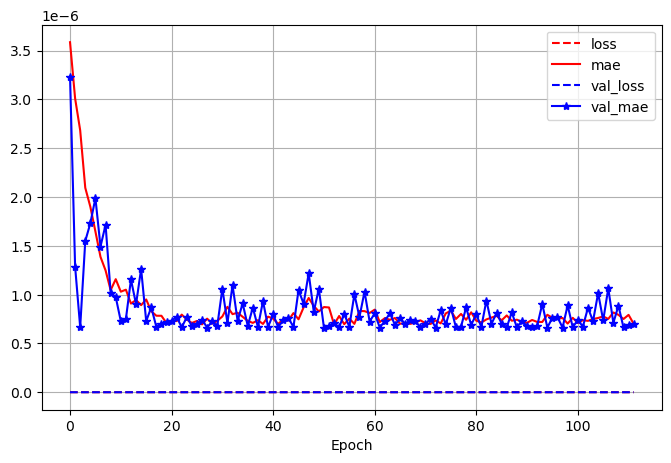

In [9]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(
    figsize = (8,5), grid=True, xlabel="Epoch",
    style=["r--", "r-", "b--", "b-*"]
)
plt.show()

#### Forecating Several Time Steps Ahead

In [10]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None,1]),
    tf.keras.layers.Dense(1)
])

In [11]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [12]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets = rail_train[seq_length:],
    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length = seq_length,
    batch_size = 32
)

In [13]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True
)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

univar_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = opt,
    metrics=["mae"]
)

history = univar_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=early_stopping_cb)

Epoch 1/500
33/33 [==============================] - 2s 18ms/step - loss: 0.0383 - mae: 0.2111 - val_loss: 0.0124 - val_mae: 0.1428
Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0108 - mae: 0.1177 - val_loss: 0.0066 - val_mae: 0.0931
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0076 - mae: 0.0942 - val_loss: 0.0042 - val_mae: 0.0701
Epoch 4/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0056 - mae: 0.0787 - val_loss: 0.0035 - val_mae: 0.0657
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0049 - mae: 0.0723 - val_loss: 0.0035 - val_mae: 0.0664
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0046 - mae: 0.0690 - val_loss: 0.0032 - val_mae: 0.0611
Epoch 7/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0044 - mae: 0.0663 - val_loss: 0.0032 - val_mae: 0.0610
Epoch 8/500
33/33 [==============================] - 0s 12ms/step - loss: 0.

33/33 [==============================] - 0s 11ms/step - loss: 0.0025 - mae: 0.0407 - val_loss: 0.0022 - val_mae: 0.0361
Epoch 63/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0026 - mae: 0.0438 - val_loss: 0.0018 - val_mae: 0.0322
Epoch 64/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0407 - val_loss: 0.0018 - val_mae: 0.0323
Epoch 65/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0420 - val_loss: 0.0018 - val_mae: 0.0311
Epoch 66/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0401 - val_loss: 0.0019 - val_mae: 0.0366
Epoch 67/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0024 - mae: 0.0408 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 68/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0414 - val_loss: 0.0018 - val_mae: 0.0346
Epoch 69/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0024 

In [15]:
import numpy as np

predictions = []
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    predictions.append(y_pred_one[0, 0])
    X = np.concatenate([X[:, 1:, :], y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 22ms/step


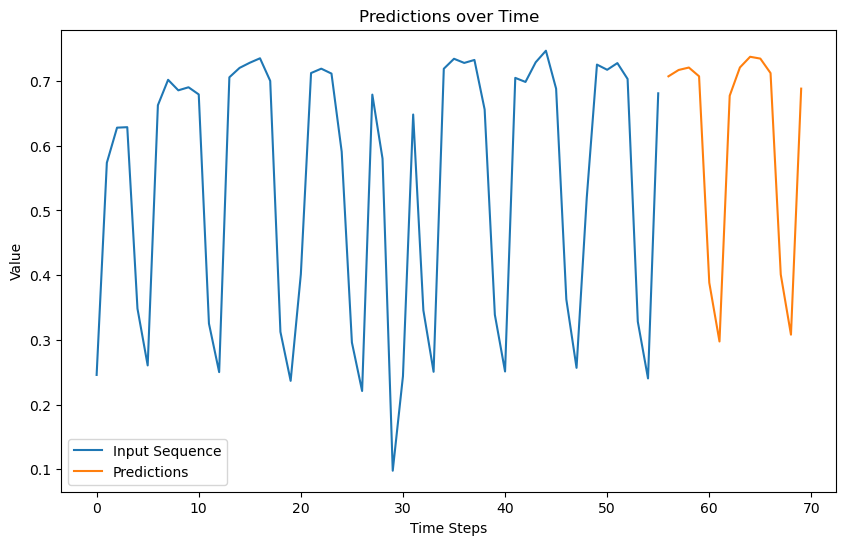

In [16]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(seq_length), rail_valid.to_numpy()[:seq_length], label='Input Sequence')
plt.plot(range(seq_length, seq_length + 14), predictions, label='Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.title('Predictions over Time')
plt.show()

#### Single Shot To Predict Next 14 Values

In [17]:
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:,:ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length+14,
    batch_size = 32,
    shuffle = True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length+14,
    batch_size = 32,
).map(split_inputs_and_targets)

In [18]:
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None,5]),
    tf.keras.layers.Dense(14)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True
)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

ahead_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = opt,
    metrics=["mae"]
)

history = ahead_model.fit(ahead_train_ds, validation_data=ahead_valid_ds, epochs=500, callbacks=early_stopping_cb)

Epoch 1/500
33/33 [==============================] - 2s 14ms/step - loss: 9.2299e-13 - mae: 1.0513e-06 - val_loss: 4.2516e-13 - val_mae: 7.6834e-07
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 3.4931e-13 - mae: 6.6264e-07 - val_loss: 3.2054e-13 - val_mae: 6.3930e-07
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2362e-13 - mae: 6.3695e-07 - val_loss: 3.1823e-13 - val_mae: 6.2767e-07
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2310e-13 - mae: 6.3678e-07 - val_loss: 3.1538e-13 - val_mae: 6.3496e-07
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2102e-13 - mae: 6.3592e-07 - val_loss: 3.1658e-13 - val_mae: 6.3241e-07
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2388e-13 - mae: 6.3928e-07 - val_loss: 3.2977e-13 - val_mae: 6.3166e-07
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2445e-13 - mae: 6.3964e-07 - val_loss: 3.1

33/33 [==============================] - 0s 6ms/step - loss: 3.2095e-13 - mae: 6.3527e-07 - val_loss: 3.1965e-13 - val_mae: 6.4256e-07
Epoch 57/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2201e-13 - mae: 6.3632e-07 - val_loss: 3.1869e-13 - val_mae: 6.3359e-07
Epoch 58/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2081e-13 - mae: 6.3696e-07 - val_loss: 3.1981e-13 - val_mae: 6.3282e-07
Epoch 59/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2288e-13 - mae: 6.3836e-07 - val_loss: 3.2294e-13 - val_mae: 6.2952e-07
Epoch 60/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2091e-13 - mae: 6.3554e-07 - val_loss: 3.2803e-13 - val_mae: 6.3699e-07
Epoch 61/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2274e-13 - mae: 6.3864e-07 - val_loss: 3.2046e-13 - val_mae: 6.3399e-07
Epoch 62/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2063e-13 - mae: 6.3714e-07 - val_loss: 3.2214e-13

In [19]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred = ahead_model.predict(X)
y_pred

1/1 [==============================] - 0s 202ms/step


array([[ 3.5881800e-07,  2.0930527e-06,  1.7200290e-06, -3.1292822e-07,
         2.9023943e-06, -1.9393893e-07,  3.9430556e-06,  2.3601876e-06,
         1.1105803e-06, -8.7830739e-07, -6.0933689e-07, -2.6440348e-06,
        -7.5056516e-07, -9.3621645e-07]], dtype=float32)

#### Forecasting Using a Sequence-to-Sequence Model

In [20]:
def to_windows(dataset, length):
    dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [21]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 3, 4, 5], dtype=int64)>]

In [49]:
def to_windows(dataset, window_size):
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    return dataset

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [50]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [51]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [52]:
tf.random.set_seed(42)
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 2s 24ms/step - loss: 6.8798e-04 - mae: 0.0179 - val_loss: 2.1808e-05 - val_mae: 0.0055
Epoch 2/500
33/33 [==============================] - 1s 14ms/step - loss: 1.2579e-05 - mae: 0.0036 - val_loss: 8.6498e-07 - val_mae: 0.0011
Epoch 3/500
33/33 [==============================] - 1s 14ms/step - loss: 4.1466e-07 - mae: 6.2995e-04 - val_loss: 3.6185e-08 - val_mae: 2.2409e-04
Epoch 4/500
33/33 [==============================] - 1s 15ms/step - loss: 1.5996e-08 - mae: 1.2165e-04 - val_loss: 3.9157e-09 - val_mae: 6.0676e-05
Epoch 5/500
33/33 [==============================] - 1s 15ms/step - loss: 2.8403e-09 - mae: 3.9877e-05 - val_loss: 2.3062e-09 - val_mae: 3.2715e-05
Epoch 6/500
33/33 [==============================] - 1s 14ms/step - loss: 2.1649e-09 - mae: 2.7794e-05 - val_loss: 2.0542e-09 - val_mae: 2.6167e-05
Epoch 7/500
33/33 [==============================] - 1s 16ms/step - loss: 1.9873e-09 - mae: 2.4471e-05 - val_loss: 1.9224e-09 - 

33/33 [==============================] - 1s 18ms/step - loss: 5.1710e-10 - mae: 1.2627e-05 - val_loss: 5.1003e-10 - val_mae: 1.2541e-05
Epoch 57/500
33/33 [==============================] - 1s 18ms/step - loss: 5.0394e-10 - mae: 1.2465e-05 - val_loss: 4.9705e-10 - val_mae: 1.2380e-05
Epoch 58/500
33/33 [==============================] - 1s 17ms/step - loss: 4.9112e-10 - mae: 1.2306e-05 - val_loss: 4.8440e-10 - val_mae: 1.2222e-05
Epoch 59/500
33/33 [==============================] - 1s 16ms/step - loss: 4.7862e-10 - mae: 1.2150e-05 - val_loss: 4.7207e-10 - val_mae: 1.2066e-05
Epoch 60/500
33/33 [==============================] - 1s 16ms/step - loss: 4.6644e-10 - mae: 1.1995e-05 - val_loss: 4.6006e-10 - val_mae: 1.1911e-05
Epoch 61/500
33/33 [==============================] - 1s 18ms/step - loss: 4.5457e-10 - mae: 1.1842e-05 - val_loss: 4.4835e-10 - val_mae: 1.1759e-05
Epoch 62/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4301e-10 - mae: 1.1690e-05 - val_loss: 4.3

Epoch 111/500
33/33 [==============================] - 1s 15ms/step - loss: 1.2544e-10 - mae: 6.2586e-06 - val_loss: 1.2371e-10 - val_mae: 6.2139e-06
Epoch 112/500
33/33 [==============================] - 1s 15ms/step - loss: 1.2225e-10 - mae: 6.1787e-06 - val_loss: 1.2057e-10 - val_mae: 6.1386e-06
Epoch 113/500
33/33 [==============================] - 1s 16ms/step - loss: 1.1915e-10 - mae: 6.1028e-06 - val_loss: 1.1751e-10 - val_mae: 6.0581e-06
Epoch 114/500
33/33 [==============================] - 1s 15ms/step - loss: 1.1613e-10 - mae: 6.0252e-06 - val_loss: 1.1452e-10 - val_mae: 5.9838e-06
Epoch 115/500
33/33 [==============================] - 1s 17ms/step - loss: 1.1318e-10 - mae: 5.9503e-06 - val_loss: 1.1162e-10 - val_mae: 5.9079e-06
Epoch 116/500
33/33 [==============================] - 1s 14ms/step - loss: 1.1031e-10 - mae: 5.8752e-06 - val_loss: 1.0879e-10 - val_mae: 5.8339e-06
Epoch 117/500
33/33 [==============================] - 1s 16ms/step - loss: 1.0751e-10 - mae: 5.7993

33/33 [==============================] - 1s 15ms/step - loss: 3.1447e-11 - mae: 3.2123e-06 - val_loss: 3.1005e-11 - val_mae: 3.1901e-06
Epoch 166/500
33/33 [==============================] - 1s 16ms/step - loss: 3.0656e-11 - mae: 3.1751e-06 - val_loss: 3.0224e-11 - val_mae: 3.1505e-06
Epoch 167/500
33/33 [==============================] - 1s 14ms/step - loss: 2.9885e-11 - mae: 3.1371e-06 - val_loss: 2.9465e-11 - val_mae: 3.1148e-06
Epoch 168/500
33/33 [==============================] - 1s 17ms/step - loss: 2.9134e-11 - mae: 3.1012e-06 - val_loss: 2.8724e-11 - val_mae: 3.0751e-06
Epoch 169/500
33/33 [==============================] - 1s 17ms/step - loss: 2.8402e-11 - mae: 3.0618e-06 - val_loss: 2.8003e-11 - val_mae: 3.0395e-06
Epoch 170/500
33/33 [==============================] - 1s 16ms/step - loss: 2.7689e-11 - mae: 3.0264e-06 - val_loss: 2.7299e-11 - val_mae: 3.0037e-06
Epoch 171/500
33/33 [==============================] - 1s 15ms/step - loss: 2.6994e-11 - mae: 2.9883e-06 - val_los

Epoch 220/500
33/33 [==============================] - 1s 15ms/step - loss: 7.9101e-12 - mae: 1.7497e-06 - val_loss: 7.7933e-12 - val_mae: 1.7357e-06
Epoch 221/500
33/33 [==============================] - 1s 17ms/step - loss: 7.7187e-12 - mae: 1.7326e-06 - val_loss: 7.6045e-12 - val_mae: 1.7187e-06
Epoch 222/500
33/33 [==============================] - 1s 15ms/step - loss: 7.5322e-12 - mae: 1.7164e-06 - val_loss: 7.4203e-12 - val_mae: 1.7006e-06
Epoch 223/500
33/33 [==============================] - 1s 16ms/step - loss: 7.3504e-12 - mae: 1.6993e-06 - val_loss: 7.2418e-12 - val_mae: 1.6852e-06
Epoch 224/500
33/33 [==============================] - 1s 15ms/step - loss: 7.1732e-12 - mae: 1.6832e-06 - val_loss: 7.0668e-12 - val_mae: 1.6699e-06
Epoch 225/500
33/33 [==============================] - 1s 14ms/step - loss: 7.0006e-12 - mae: 1.6665e-06 - val_loss: 6.8973e-12 - val_mae: 1.6545e-06
Epoch 226/500
33/33 [==============================] - 1s 15ms/step - loss: 6.8325e-12 - mae: 1.6499

33/33 [==============================] - 1s 16ms/step - loss: 2.2617e-12 - mae: 1.1267e-06 - val_loss: 2.2247e-12 - val_mae: 1.1168e-06
Epoch 275/500
33/33 [==============================] - 1s 13ms/step - loss: 2.2143e-12 - mae: 1.1193e-06 - val_loss: 2.1774e-12 - val_mae: 1.1098e-06
Epoch 276/500
33/33 [==============================] - 1s 14ms/step - loss: 2.1679e-12 - mae: 1.1133e-06 - val_loss: 2.1320e-12 - val_mae: 1.1028e-06
Epoch 277/500
33/33 [==============================] - 1s 15ms/step - loss: 2.1230e-12 - mae: 1.1058e-06 - val_loss: 2.0878e-12 - val_mae: 1.0956e-06
Epoch 278/500
33/33 [==============================] - 1s 14ms/step - loss: 2.0787e-12 - mae: 1.0993e-06 - val_loss: 2.0442e-12 - val_mae: 1.0896e-06
Epoch 279/500
33/33 [==============================] - 1s 14ms/step - loss: 2.0359e-12 - mae: 1.0926e-06 - val_loss: 2.0020e-12 - val_mae: 1.0835e-06
Epoch 280/500
33/33 [==============================] - 1s 14ms/step - loss: 1.9942e-12 - mae: 1.0871e-06 - val_los

Epoch 329/500
33/33 [==============================] - 1s 16ms/step - loss: 8.4737e-13 - mae: 8.6999e-07 - val_loss: 8.3053e-13 - val_mae: 8.6250e-07
Epoch 330/500
33/33 [==============================] - 1s 14ms/step - loss: 8.3591e-13 - mae: 8.6773e-07 - val_loss: 8.1940e-13 - val_mae: 8.5945e-07
Epoch 331/500
33/33 [==============================] - 1s 16ms/step - loss: 8.2491e-13 - mae: 8.6439e-07 - val_loss: 8.0834e-13 - val_mae: 8.5659e-07
Epoch 332/500
33/33 [==============================] - 1s 15ms/step - loss: 8.1382e-13 - mae: 8.6176e-07 - val_loss: 7.9757e-13 - val_mae: 8.5436e-07
Epoch 333/500
33/33 [==============================] - 1s 16ms/step - loss: 8.0334e-13 - mae: 8.5921e-07 - val_loss: 7.8778e-13 - val_mae: 8.5221e-07
Epoch 334/500
33/33 [==============================] - 1s 16ms/step - loss: 7.9270e-13 - mae: 8.5656e-07 - val_loss: 7.7715e-13 - val_mae: 8.4878e-07
Epoch 335/500
33/33 [==============================] - 1s 15ms/step - loss: 7.8271e-13 - mae: 8.5375

33/33 [==============================] - 1s 14ms/step - loss: 5.0800e-13 - mae: 7.6789e-07 - val_loss: 4.9789e-13 - val_mae: 7.6174e-07
Epoch 384/500
33/33 [==============================] - 1s 15ms/step - loss: 5.0522e-13 - mae: 7.6680e-07 - val_loss: 4.9430e-13 - val_mae: 7.6034e-07
Epoch 385/500
33/33 [==============================] - 1s 15ms/step - loss: 5.0232e-13 - mae: 7.6554e-07 - val_loss: 4.9073e-13 - val_mae: 7.5854e-07
Epoch 386/500
33/33 [==============================] - 1s 14ms/step - loss: 4.9982e-13 - mae: 7.6456e-07 - val_loss: 4.8846e-13 - val_mae: 7.5774e-07
Epoch 387/500
33/33 [==============================] - 1s 15ms/step - loss: 4.9711e-13 - mae: 7.6357e-07 - val_loss: 4.8553e-13 - val_mae: 7.5642e-07
Epoch 388/500
33/33 [==============================] - 1s 14ms/step - loss: 4.9451e-13 - mae: 7.6217e-07 - val_loss: 4.8328e-13 - val_mae: 7.5541e-07
Epoch 389/500
33/33 [==============================] - 1s 15ms/step - loss: 4.9177e-13 - mae: 7.6095e-07 - val_los

Epoch 438/500
33/33 [==============================] - 1s 17ms/step - loss: 4.2293e-13 - mae: 7.2449e-07 - val_loss: 4.1315e-13 - val_mae: 7.1823e-07
Epoch 439/500
33/33 [==============================] - 1s 14ms/step - loss: 4.2227e-13 - mae: 7.2407e-07 - val_loss: 4.1218e-13 - val_mae: 7.1769e-07
Epoch 440/500
33/33 [==============================] - 1s 15ms/step - loss: 4.2168e-13 - mae: 7.2365e-07 - val_loss: 4.1194e-13 - val_mae: 7.1744e-07
Epoch 441/500
33/33 [==============================] - 1s 15ms/step - loss: 4.2090e-13 - mae: 7.2303e-07 - val_loss: 4.1132e-13 - val_mae: 7.1685e-07
Epoch 442/500
33/33 [==============================] - 1s 16ms/step - loss: 4.2031e-13 - mae: 7.2259e-07 - val_loss: 4.1050e-13 - val_mae: 7.1639e-07
Epoch 443/500
33/33 [==============================] - 1s 16ms/step - loss: 4.1968e-13 - mae: 7.2220e-07 - val_loss: 4.1031e-13 - val_mae: 7.1614e-07
Epoch 444/500
33/33 [==============================] - 1s 16ms/step - loss: 4.1907e-13 - mae: 7.2169

33/33 [==============================] - 1s 14ms/step - loss: 4.0262e-13 - mae: 7.0709e-07 - val_loss: 3.9470e-13 - val_mae: 7.0203e-07
Epoch 493/500
33/33 [==============================] - 1s 13ms/step - loss: 4.0231e-13 - mae: 7.0674e-07 - val_loss: 3.9278e-13 - val_mae: 7.0088e-07
Epoch 494/500
33/33 [==============================] - 1s 15ms/step - loss: 4.0232e-13 - mae: 7.0674e-07 - val_loss: 3.9287e-13 - val_mae: 7.0067e-07
Epoch 495/500
33/33 [==============================] - 1s 17ms/step - loss: 4.0205e-13 - mae: 7.0639e-07 - val_loss: 3.9263e-13 - val_mae: 7.0044e-07
Epoch 496/500
33/33 [==============================] - 1s 16ms/step - loss: 4.0185e-13 - mae: 7.0612e-07 - val_loss: 3.9272e-13 - val_mae: 7.0069e-07
Epoch 497/500
33/33 [==============================] - 1s 15ms/step - loss: 4.0177e-13 - mae: 7.0597e-07 - val_loss: 3.9349e-13 - val_mae: 7.0073e-07
Epoch 498/500
33/33 [==============================] - 1s 15ms/step - loss: 4.0153e-13 - mae: 7.0568e-07 - val_los

0.7002236657172034